# Load PTQ Experiments

In [1]:
import incense
from common.helper.config import parseMongoConfig

loader = incense.ExperimentLoader(
    **parseMongoConfig('../config.ini', adapt='IncenseExperimentLoader'))
all_ptq_experiments_query = {
    '$and': [{
        'experiment.name': 'PTQ_CNN-IMU'
    }, {
        'status': 'COMPLETED'
    }, {
        '_id': {
            '$gte': 792
        }
    }]
}
all_experiments = loader.find(all_ptq_experiments_query)
print(f'Loaded {len(all_experiments)} PTQ Experiments')

base_experiment_by_dataset = {}
for ex in all_experiments:
  cfg = ex.to_dict()['config']
  if cfg['use_dataset'] in base_experiment_by_dataset:
    assert base_experiment_by_dataset[cfg['use_dataset']] == cfg['trained_model_run_id']
  else:
    base_experiment_by_dataset[cfg['use_dataset']] = cfg['trained_model_run_id']
base_experiment_by_dataset = {
    d: loader.find_by_id(e_id) for d, e_id in base_experiment_by_dataset.items()
}
print(f'Base Experiments {base_experiment_by_dataset}')

/home/jroeger/data/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 774 PTQ Experiments
Base Experiments {'opportunity': Experiment(id=787, name=CNN-IMU_Opportunity-Locomotion), 'pamap2': Experiment(id=788, name=CNN-IMU_Pamap2(activity_labels)), 'lara': Experiment(id=786, name=CNN-IMU_LARa)}


# Compare observer configirations for 7 bit precision

Select the Top $k$ models by their $wF_1$ score on the test set. Plot their corresponding 
median times for analyzing a calibration batch of size 128.

Number of observer variance experiments = 54


Top #,opportunity,pamap2,lara
1,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric
2,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric
3,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric
4,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full
5,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric
6,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full
7,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint
8,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full
9,activation_observer: torch.ao.quantization.HistogramObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full
10,activation_observer: torch.ao.quantization.HistogramObserver weight_

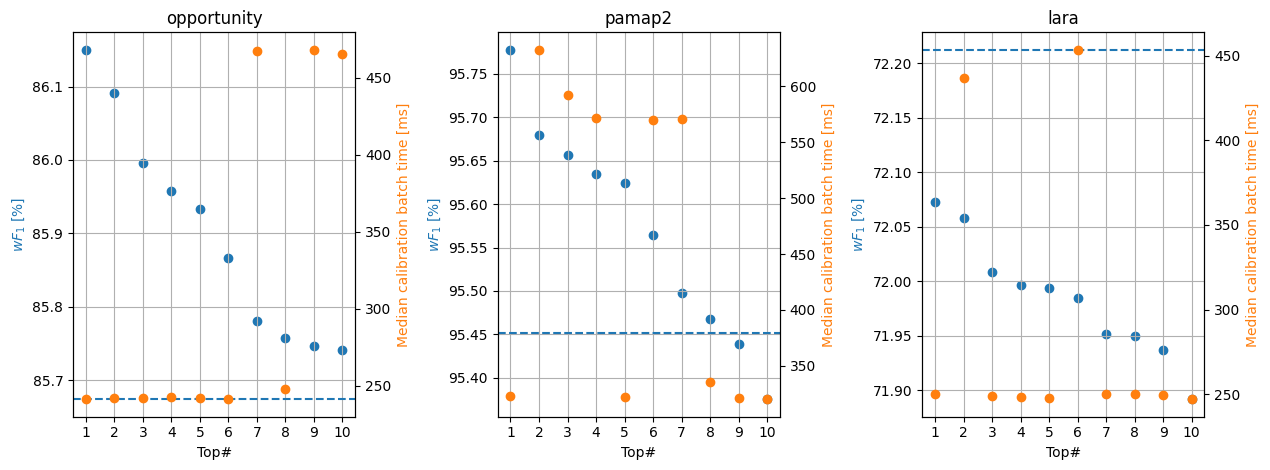

In [2]:
import matplotlib.pyplot as plt
from common.eval.experiments import metricTopK, configSubset
from tabulate import tabulate
from collections import defaultdict
import numpy as np
from matplotlib import cm

observer_vairance_experiments = list(
    filter(lambda e: e.to_dict()['meta']['my_meta']['runner'] == 'ptq_cnn_imu_run_observer.py',
           all_experiments))
print(f'Number of observer variance experiments = {len(observer_vairance_experiments)}')

observer_var_by_dataset = defaultdict(list)
for ex in observer_vairance_experiments:
  observer_var_by_dataset[ex.to_dict()['config']['use_dataset']].append(ex)

config_subset = [
    'activation_observer',
    'weight_observer',
    'weight_range',
]


def cell(ex) -> str:
  ret = ''
  for k, v in configSubset(ex, config_subset).items():
    ret += f'  {k:<15}: {v}\n'
  return ret


def point_wf1(ex) -> float:
  return ex.metrics['test/wf1'].max()


def point_time(ex) -> float:
  return ex.metrics['calibration/batch_time'].median()


top_k = 10
top_k_by_dataset = {
    k: metricTopK(exs, 'test/wf1', top_k) for k, exs in observer_var_by_dataset.items()
}
cmap = cm.get_cmap('tab10')

fig, axs = plt.subplots(1, len(top_k_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
for ix, (dataset, experiments) in enumerate(top_k_by_dataset.items()):
  top_wf1 = np.array(list(map(point_wf1, experiments)))
  top_tme = np.array(list(map(point_time, experiments)))
  top_ixs = np.arange(start=1, stop=top_wf1.shape[0] + 1)
  axs[ix].scatter(x=top_ixs, y=top_wf1 * 100, color=cmap(0), label='$wF_1$')
  tx = axs[ix].twinx()
  tx.scatter(x=top_ixs, y=top_tme * 1000, color=cmap(1), label='batch_time')
  axs[ix].set_title(dataset)
  axs[ix].set_ylabel('$wF_1$ [%]', color=cmap(0))
  tx.set_ylabel('Median calibration batch time [ms]', color=cmap(1))
  axs[ix].set_xlabel('Top#')
  axs[ix].grid()
  axs[ix].set_xticks(top_ixs)
  axs[ix].axhline(y=point_wf1(base_experiment_by_dataset[dataset]) * 100, linestyle='dashed')
fig.tight_layout()
fig.show()

table_header = ['Top #'] + list(top_k_by_dataset.keys())
table_data = zip(range(1, top_k + 1),
                 *[[cell(e) for e in exs] for _, exs in top_k_by_dataset.items()])
tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')

Now sort all models by the median calibration batch-time and make boxplots of all calibration batch-times.  Also scatter their $wF_1$ scores on the test set.

Top #,opportunity,pamap2,lara
1,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint
2,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric
3,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full
4,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric
5,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint
6,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full
7,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric
8,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : uint,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : uint
9,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : symmetric,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.PerChannelMinMaxObserver weight_range : full,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver weight_observer: torch.ao.quantization.MinMaxObserver weight_range : full
10,activation_observer: torch.ao.quantization.MovingAverageMinMaxObserver we

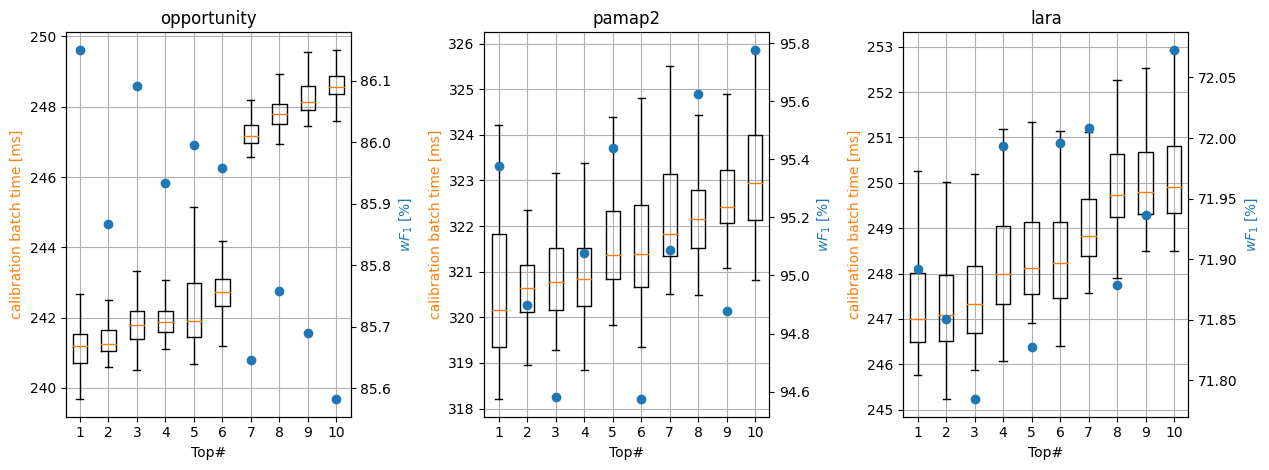

In [3]:
import matplotlib.pyplot as plt
from common.eval.experiments import metricTopK
from tabulate import tabulate
from collections import defaultdict
import numpy as np
from matplotlib import cm

def point_wf1(ex) -> float:
  return ex.metrics['test/wf1'].max()


def times(ex) -> float:
  return ex.metrics['calibration/batch_time']


top_k = 10
top_k_by_dataset = {
    k: metricTopK(exs, 'calibration/batch_time', top_k, mode='min', fold='median') for k, exs in observer_var_by_dataset.items()
}
cmap = cm.get_cmap('tab10')

fig, axs = plt.subplots(1, len(top_k_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
for ix, (dataset, experiments) in enumerate(top_k_by_dataset.items()):
  top_wf1 = np.array(list(map(point_wf1, experiments)))
  top_ixs = np.arange(start=1, stop=top_wf1.shape[0] + 1)
  axs[ix].boxplot(x=[times(e)*1000 for e in experiments], showfliers=False)
  tx = axs[ix].twinx()
  tx.scatter(x=top_ixs, y=top_wf1 * 100, color=cmap(0), label='$wF_1$ [%]')
  axs[ix].set_title(dataset)
  axs[ix].set_ylabel('calibration batch time [ms]', color=cmap(1))
  tx.set_ylabel('$wF_1$ [%]', color=cmap(0))
  axs[ix].set_xlabel('Top#')
  axs[ix].grid()
  axs[ix].set_xticks(top_ixs)
fig.tight_layout()
fig.show()

table_header = ['Top #'] + list(top_k_by_dataset.keys())
table_data = zip(range(1, top_k + 1),
                 *[[cell(e) for e in exs] for _, exs in top_k_by_dataset.items()])
tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')

# Impact of the MovingAverageObserver at 7 bit precision

For all configurations, calculate the absolute $wF_1$ score difference by choosing a `MovingAverageMinMaxObserver`
over an `MinMaxObserver`.

Index,opportunity,pamap2,lara
1,"('torch.ao.quantization.MinMaxObserver', 'full')","('torch.ao.quantization.MinMaxObserver', 'full')","('torch.ao.quantization.PerChannelMinMaxObserver', 'full')"
2,"('torch.ao.quantization.MinMaxObserver', 'symmetric')","('torch.ao.quantization.PerChannelMinMaxObserver', 'symmetric')","('torch.ao.quantization.PerChannelMinMaxObserver', 'symmetric')"
3,"('torch.ao.quantization.PerChannelMinMaxObserver', 'full')","('torch.ao.quantization.MinMaxObserver', 'symmetric')","('torch.ao.quantization.MinMaxObserver', 'symmetric')"
4,"('torch.ao.quantization.MinMaxObserver', 'uint')","('torch.ao.quantization.PerChannelMinMaxObserver', 'uint')","('torch.ao.quantization.MinMaxObserver', 'uint')"
5,"('torch.ao.quantization.PerChannelMinMaxObserver', 'symmetric')","('torch.ao.quantization.PerChannelMinMaxObserver', 'full')","('torch.ao.quantization.PerChannelMinMaxObserver', 'uint')"
6,"('torch.ao.quantization.PerChannelMinMaxObserver', 'uint')","('torch.ao.quantization.MinMaxObserver', 'uint')","('torch.ao.quantization.MinMaxObserver', 'full')"


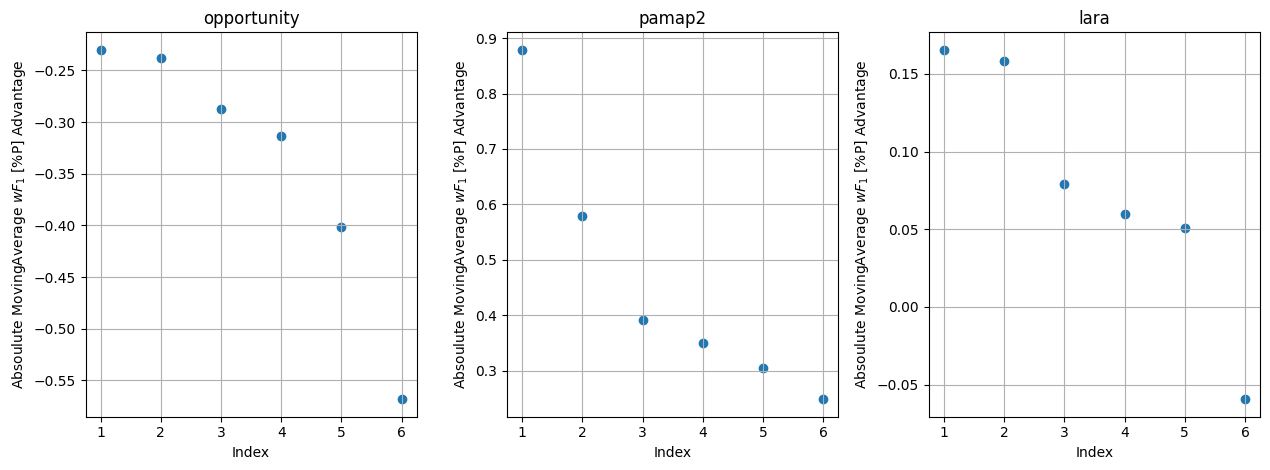

In [4]:
config_eq = {
    'activation_observer',
    'weight_observer',
    'weight_range',
}
config_diff = {
    'activation_observer': [
        'torch.ao.quantization.MinMaxObserver', 'torch.ao.quantization.MovingAverageMinMaxObserver'
    ]
}
config_eq = config_eq.difference(config_diff.keys())

ex_moving_minus_by_dataset = {}
for dataset, experiments in observer_var_by_dataset.items():
  ex_bins = defaultdict(lambda: defaultdict(list))
  for ex in experiments:
    subset_e = configSubset(ex, config_eq)
    subset_d = configSubset(ex, config_diff.keys())
    if all([v in config_diff[k] for k, v in subset_d.items()]):
      ex_bins[tuple(subset_e.values())][tuple(subset_d.values())].append(ex)

  ex_moving_minus_non_moving = {
      cfg: point_wf1(exs[config_diff['activation_observer'][1],][0]) -
      point_wf1(exs[config_diff['activation_observer'][0],][0]) for cfg, exs in ex_bins.items()
  }

  ex_moving_minus_by_dataset[dataset] = dict(sorted(ex_moving_minus_non_moving.items(), key=lambda x:x[1], reverse=True))



fig, axs = plt.subplots(1, len(ex_moving_minus_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
xs = []
for ix, (dataset, experiments) in enumerate(ex_moving_minus_by_dataset.items()):
  xs = np.array(range(1, len(experiments)+1))
  ys = np.array(list(experiments.values()))
  axs[ix].scatter(x=xs, y=ys*100)
  axs[ix].set_ylabel(f'Absoulute MovingAverage $wF_1$ [%P] Advantage')
  axs[ix].set_xlabel('Index')
  axs[ix].set_xticks(xs)
  axs[ix].set_title(dataset)
  axs[ix].grid()
fig.tight_layout()
fig.show()

table_header = ['Index'] + list(ex_moving_minus_by_dataset.keys())
table_data = zip(xs, *[[str(cfg) for cfg in exs] for exs in ex_moving_minus_by_dataset.values()])
tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')


# Inference time gain

Since all statically quantized models technically have the same inference time, select the best model
for each dataset and compare the inference time to the baseline model.

[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol R from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matplotlib.mathtext] Substituting symbol Z from STIXGeneral
[INF][matp

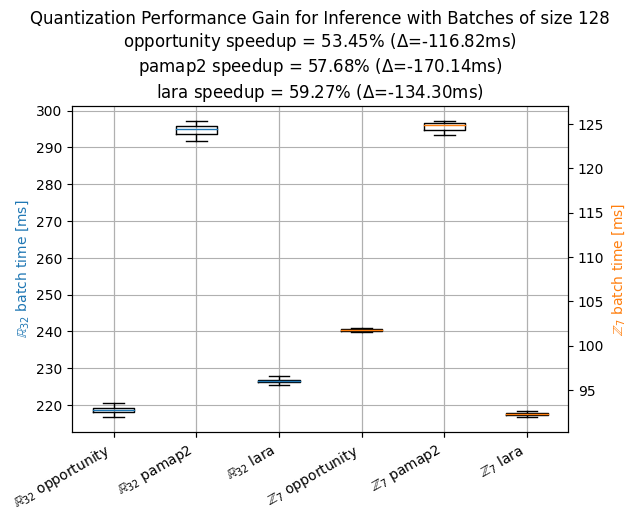

In [5]:
from common.eval.experiments import metricBest

ptq_rep_ex_by_dataset = {
  ds: metricBest(exs, metric='test/wf1', mode='max')
  for ds, exs in observer_var_by_dataset.items()
}


labels = []
xs_fp32 = []
xs_int8 = []
for dataset in base_experiment_by_dataset:
  labels.append(f'$\\mathbb{{R}}_{{32}}$ {dataset}')
  xs_fp32.append(base_experiment_by_dataset[dataset].metrics['test/batch_time']*1000)
  xs_int8.append([])
for dataset in ptq_rep_ex_by_dataset:
  labels.append(f'$\\mathbb{{Z}}_{{7}}$ {dataset}')
  xs_int8.append(ptq_rep_ex_by_dataset[dataset].metrics['test/batch_time']*1000)
  xs_fp32.append([])

before_after_median_by_dataset={
  dataset: (base_experiment_by_dataset[dataset].metrics['test/batch_time'].median(), ptq_rep_ex_by_dataset[dataset].metrics['test/batch_time'].median())
  for dataset in base_experiment_by_dataset
}

fig, ax = plt.subplots()
tx = ax.twinx()
ax.boxplot(x=xs_fp32, labels=labels, showfliers=False, medianprops={'color': cmap(0)})
tx.boxplot(x=xs_int8, labels=[""]*6, showfliers=False, medianprops={'color': cmap(1)})
ax.set_ylabel('$\\mathbb{R}_{32}$ batch time [ms]', color=cmap(0))
tx.set_ylabel('$\\mathbb{Z}_{7}$ batch time [ms]', color=cmap(1))
ax.grid()
title = f'Quantization Performance Gain for Inference with Batches of size 128'
for dataset, (before, after) in before_after_median_by_dataset.items():
  delta = after - before
  decrease = 100 * (1- (after/before))
  title += f'\n{dataset} speedup = {decrease:.02f}% ($\\Delta$={1000*delta:.02f}ms)'
ax.set_title(title)
fig.autofmt_xdate()
fig.show()

# Evaluate best configurations for each bit precision

Check how the observers impact the precision for lower bit-widths, then 7.

Number of bit variance experiments = 144


#Bits,Top 1 (lara),Top 2 (lara),Top 3 (lara),Top 4 (lara)
7,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
6,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'
5,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
4,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
3,activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
2,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'


#Bits,Top 1 (opportunity),Top 2 (opportunity),Top 3 (opportunity),Top 4 (opportunity)
7,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'
6,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
5,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'
4,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'
3,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
2,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'


#Bits,Top 1 (pamap2),Top 2 (pamap2),Top 3 (pamap2),Top 4 (pamap2)
7,activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
6,activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
5,activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
4,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static'
3,activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'
2,activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.PerChannelMinMaxObserver' io_quant='static',activation='torch.ao.quantization.HistogramObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static',activation='torch.ao.quantization.MovingAverageMinMaxObserver' weight='torch.ao.quantization.MinMaxObserver' io_quant='static'


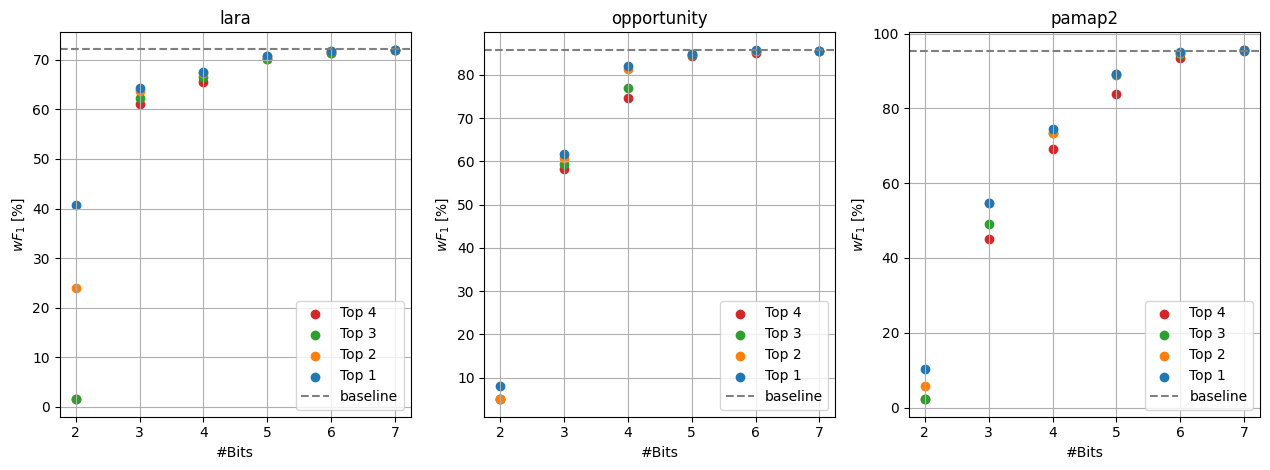

In [6]:
from IPython.display import HTML, display

bit_vairance_experiments = list(
    filter(lambda e: e.to_dict()['meta']['my_meta']['runner'] == 'ptq_cnn_imu_run_bit_depth.py',
           all_experiments))
print(f'Number of bit variance experiments = {len(bit_vairance_experiments)}')

ex_by_bits_by_dataset = defaultdict(lambda: defaultdict(list))
for ex in bit_vairance_experiments:
  cfg = configSubset(ex, keys=['use_dataset', 'n_bits'])
  if ex.to_dict()['config']['imu_input_quantization'] == 'static':
    ex_by_bits_by_dataset[cfg['use_dataset']][cfg['n_bits']].append(ex)

top_k = 4

top_k_by_bits_by_dataset = {
    dataset: {
        bits: metricTopK(exs, metric='test/wf1', k=top_k, mode='max')
        for bits, exs in sorted(ex_by_bits.items(), key=lambda x:x[0], reverse=True)
    } for dataset, ex_by_bits in ex_by_bits_by_dataset.items()
}

ex_by_bits_by_top_ix_by_dataset = defaultdict(lambda: defaultdict(dict))
for dataset, top_k_by_bits in top_k_by_bits_by_dataset.items():
  for bits, tk in top_k_by_bits.items():
    for ix, ex in enumerate(tk):
      ex_by_bits_by_top_ix_by_dataset[dataset][ix+1][bits] = ex

fig, axs = plt.subplots(1, len(ex_by_bits_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
for ix, dataset in enumerate(ex_by_bits_by_top_ix_by_dataset):
  for tk_ix, ex_by_bits in list(ex_by_bits_by_top_ix_by_dataset[dataset].items())[::-1]:
    xs = np.array(list(ex_by_bits.keys()))
    ys = np.array(list(map(lambda e: e.metrics['test/wf1'], ex_by_bits.values())))*100
    axs[ix].scatter(x=xs, y=ys, color=cmap(tk_ix-1), label=f'Top {tk_ix}')

  baseline = base_experiment_by_dataset[dataset].metrics['test/wf1'].max() * 100
  axs[ix].axhline(y=baseline, linestyle='dashed', label='baseline', color='grey')
  axs[ix].set_ylabel('$wF_1$ [%]')
  axs[ix].set_xlabel('#Bits')
  axs[ix].set_title(dataset)
  axs[ix].legend()
  axs[ix].grid()

fig.tight_layout()
fig.show()

def cell(e) -> str:
  activation = e.to_dict()['config']['activation_observer']
  weight = e.to_dict()['config']['weight_observer']
  io_quant = e.to_dict()['config']['imu_input_quantization']
  return f'{activation=} \n{weight=} \n{io_quant=}'


for dataset, ex_by_bits_by_top_ix in ex_by_bits_by_top_ix_by_dataset.items():
  table_header = ['#Bits'] + [f'Top {ix} ({dataset})' for ix in ex_by_bits_by_top_ix]
  bits = ex_by_bits_by_top_ix[1].keys()
  table_data = zip(bits, *[[cell(e) for e in ex_by_bits.values()] for ex_by_bits in ex_by_bits_by_top_ix.values()])
  display(HTML(tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')))

# Impact of mixed Quantization
Run a broad comparison of selective quantization for:
- Input Block
- Covolution Pipeline
- Pipeline FC
- Classifier FC
- Output Layer

Number of mode variance experiments (subset) = 288


#Bits,Top 1 (lara),Top 2 (lara),Top 3 (lara),Top 4 (lara)
7,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none'
6,input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
5,input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
4,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none'
3,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none'
2,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'


#Bits,Top 1 (opportunity),Top 2 (opportunity),Top 3 (opportunity),Top 4 (opportunity)
7,input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none'
6,input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='static'
5,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none'
4,input_q='static' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
3,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none'
2,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none'


#Bits,Top 1 (pamap2),Top 2 (pamap2),Top 3 (pamap2),Top 4 (pamap2)
7,input_q='static' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='static',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='static',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='static'
6,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none'
5,input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
4,input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='static'
3,input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='static' out_q='none',input_q='static' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none'
2,input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='static' fc_q='static' out_q='none',input_q='none' pipe_q='static' pipe_fc_q='static' fc_q='none' out_q='none',input_q='none' pipe_q='none' pipe_fc_q='none' fc_q='static' out_q='static'


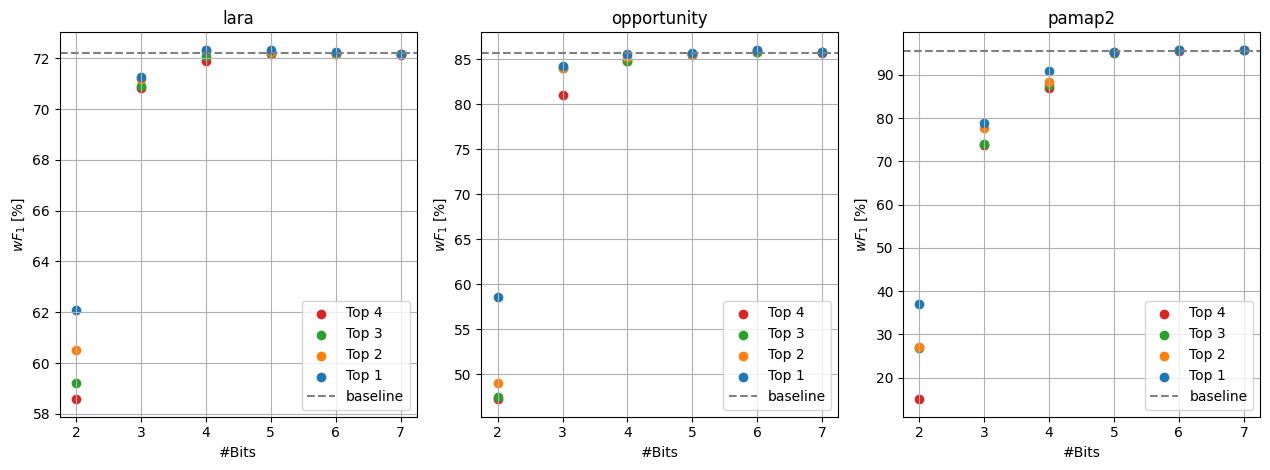

In [7]:
def predicate_mode(e) -> bool:
  return e.to_dict()['meta']['my_meta']['runner'] == 'ptq_cnn_imu_run_bit_depth_modes.py'

def predicate_subset(e) -> bool:
  cfg = e.to_dict()['config']

  pipe = cfg['imu_pipeline_quantization'] == 'static'
  pipe_fc = cfg['imu_pipeline_fc_quantization'] == 'static'
  fc = cfg['fc_quantization'] == 'static'

  return any((
      pipe and pipe_fc and not fc,
      not pipe and pipe_fc and fc,
      not pipe and not pipe_fc and fc,
      pipe and pipe_fc and fc,
  ))


mode_vairance_experiments = list(filter(predicate_mode, all_experiments))
mode_vairance_experiments_subset = list(filter(predicate_subset, mode_vairance_experiments))
print(f'Number of mode variance experiments (subset) = {len(mode_vairance_experiments_subset)}')

ex_by_bits_by_dataset = defaultdict(lambda: defaultdict(list))
for ex in mode_vairance_experiments_subset:
  cfg = configSubset(ex, keys=['use_dataset', 'n_bits'])
  ex_by_bits_by_dataset[cfg['use_dataset']][cfg['n_bits']].append(ex)

top_k = 4

top_k_by_bits_by_dataset = {
    dataset: {
        bits: metricTopK(exs, metric='test/wf1', k=top_k, mode='max')
        for bits, exs in sorted(ex_by_bits.items(), key=lambda x: x[0], reverse=True)
    } for dataset, ex_by_bits in ex_by_bits_by_dataset.items()
}

ex_by_bits_by_top_ix_by_dataset = defaultdict(lambda: defaultdict(dict))
for dataset, top_k_by_bits in top_k_by_bits_by_dataset.items():
  for bits, tk in top_k_by_bits.items():
    for ix, ex in enumerate(tk):
      ex_by_bits_by_top_ix_by_dataset[dataset][ix + 1][bits] = ex

fig, axs = plt.subplots(1, len(ex_by_bits_by_dataset))
fig.set_figwidth(fig.get_figwidth() * 2)
for ix, dataset in enumerate(ex_by_bits_by_top_ix_by_dataset):
  for tk_ix, ex_by_bits in list(ex_by_bits_by_top_ix_by_dataset[dataset].items())[::-1]:
    xs = np.array(list(ex_by_bits.keys()))
    ys = np.array(list(map(lambda e: e.metrics['test/wf1'], ex_by_bits.values()))) * 100
    axs[ix].scatter(x=xs, y=ys, color=cmap(tk_ix - 1), label=f'Top {tk_ix}')

  baseline = base_experiment_by_dataset[dataset].metrics['test/wf1'].max() * 100
  axs[ix].axhline(y=baseline, linestyle='dashed', label='baseline', color='grey')
  axs[ix].set_ylabel('$wF_1$ [%]')
  axs[ix].set_xlabel('#Bits')
  axs[ix].set_title(dataset)
  axs[ix].legend()
  axs[ix].grid()

fig.tight_layout()
fig.show()


def cell(e) -> str:
  input_q = e.to_dict()['config']['imu_input_quantization']
  pipe_q = e.to_dict()['config']['imu_pipeline_quantization']
  pipe_fc_q = e.to_dict()['config']['imu_pipeline_fc_quantization']
  fc_q = e.to_dict()['config']['fc_quantization']
  out_q = e.to_dict()['config']['output_layer_quantization']
  return f'{input_q=} \n{pipe_q=} \n{pipe_fc_q=} \n{fc_q=} \n{out_q=}'


for dataset, ex_by_bits_by_top_ix in ex_by_bits_by_top_ix_by_dataset.items():
  table_header = ['#Bits'] + [f'Top {ix} ({dataset})' for ix in ex_by_bits_by_top_ix]
  bits = ex_by_bits_by_top_ix[1].keys()
  table_data = zip(
      bits,
      *[[cell(e) for e in ex_by_bits.values()] for ex_by_bits in ex_by_bits_by_top_ix.values()])
  display(HTML(tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')))

# Time/$wF_1$ tadeoff for selected experiments

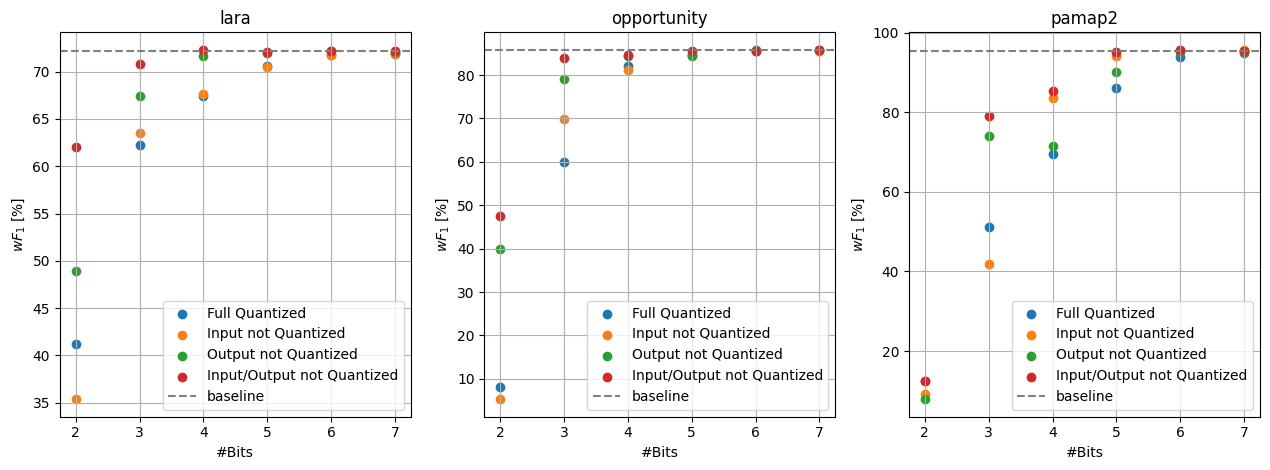

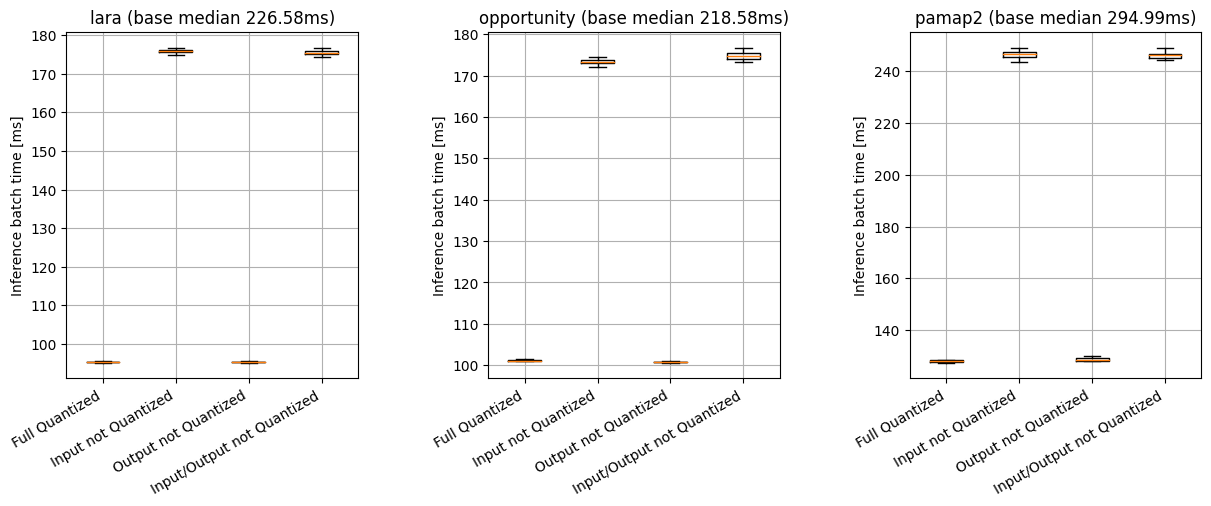

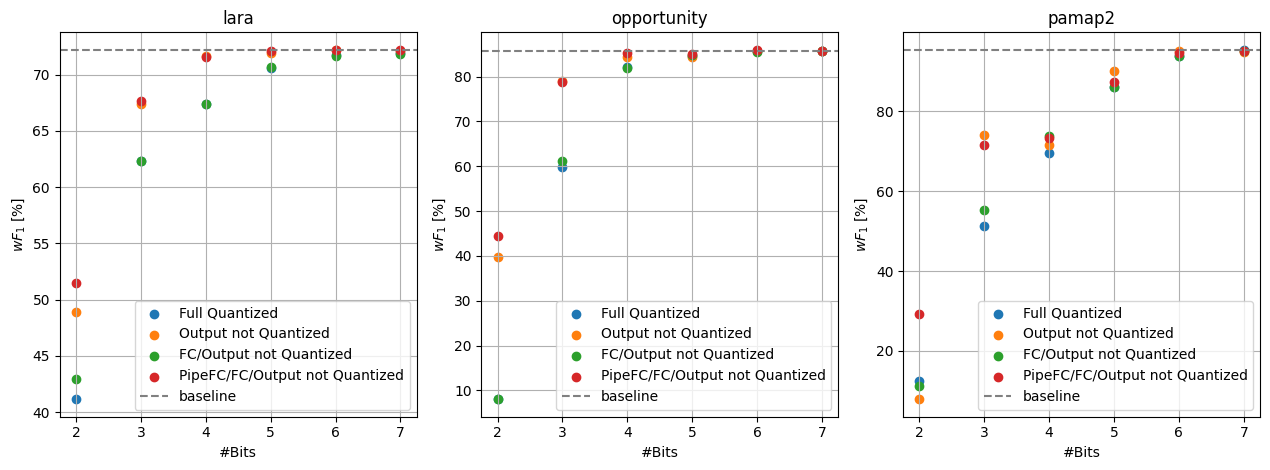

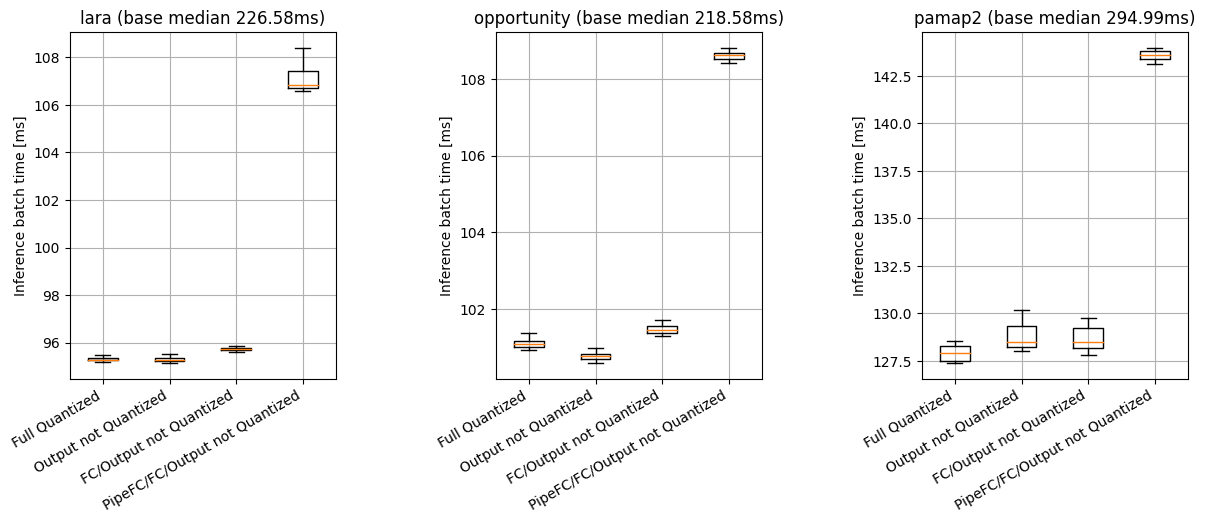

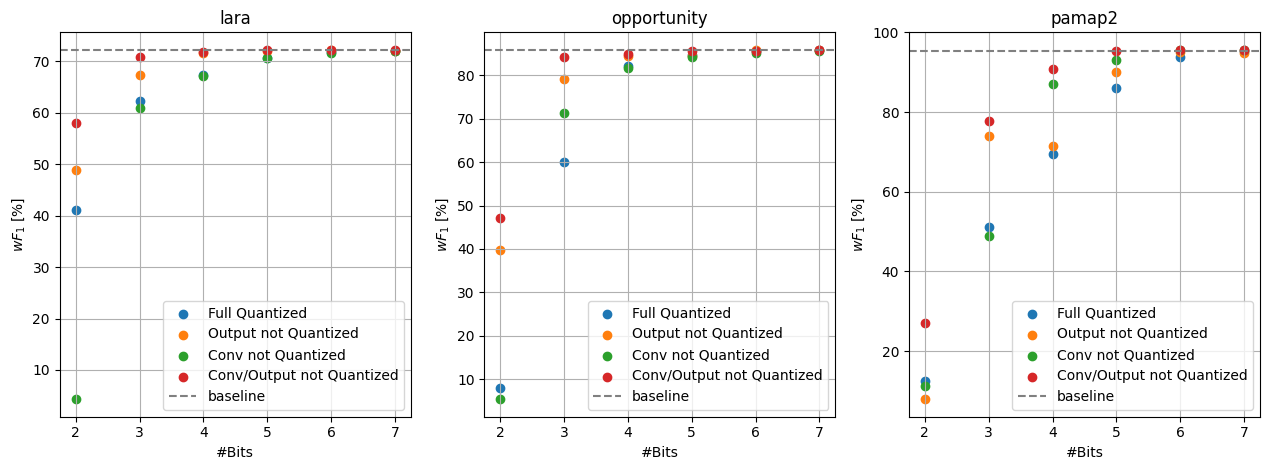

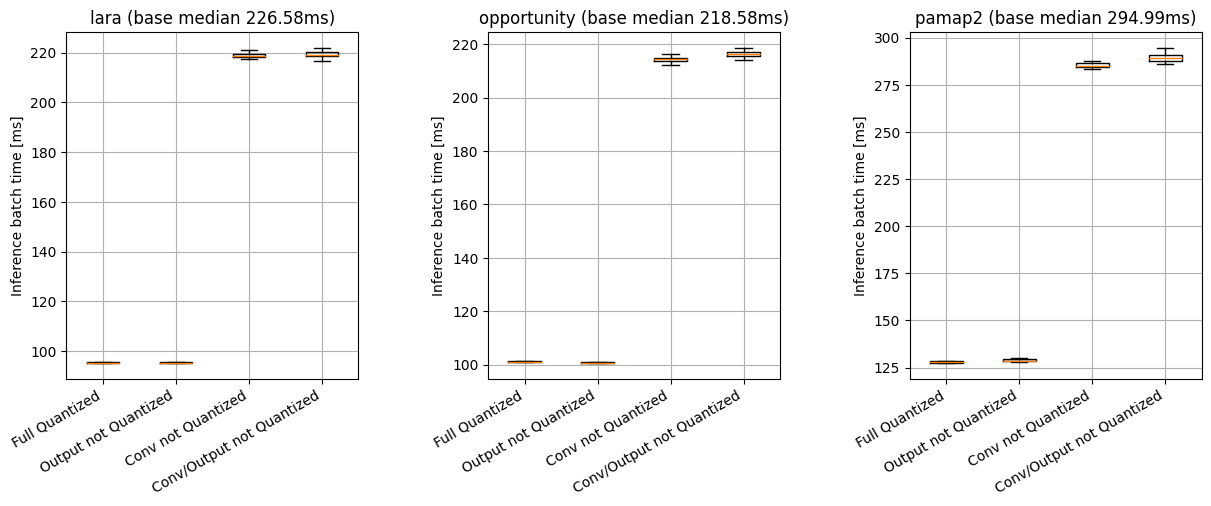

In [44]:
cfg_comparison_1 = {
    'Full Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Input not Quantized': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Output not Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'Input/Output not Quantized': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_2 = {
    'Full Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Output not Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'FC/Output not Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'none',
        'output_layer_quantization': 'static',
    },
    'PipeFC/FC/Output not Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'none',
        'fc_quantization': 'none',
        'output_layer_quantization': 'none',
    },
}

cfg_comparison_3 = {
    'Full Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Output not Quantized': {
        'imu_input_quantization': 'static',
        'imu_pipeline_quantization': 'static',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
    'Conv not Quantized': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'static',
    },
    'Conv/Output not Quantized': {
        'imu_input_quantization': 'none',
        'imu_pipeline_quantization': 'none',
        'imu_pipeline_fc_quantization': 'static',
        'fc_quantization': 'static',
        'output_layer_quantization': 'none',
    },
}

for cfg_comparison in (cfg_comparison_1, cfg_comparison_2, cfg_comparison_3):
  ex_by_bits_by_cfg_by_dataset = defaultdict(lambda: defaultdict(dict))
  for key, cfg in cfg_comparison.items():
    for ex in mode_vairance_experiments:
      cfg_subset = configSubset(ex, cfg.keys())
      if cfg_subset == cfg:
        bits = ex.to_dict()['config']['n_bits']
        dataset = ex.to_dict()['config']['use_dataset']
        d = ex_by_bits_by_cfg_by_dataset[dataset][key]
        assert bits not in d
        d[bits] = ex

  ex_by_bits_by_cfg_by_dataset = {
      dataset: {
          key: dict(sorted(ex_by_bits.items(), key=lambda x: x[0], reverse=True))
          for key, ex_by_bits in ex_by_bits_by_cfg.items()
      } for dataset, ex_by_bits_by_cfg in ex_by_bits_by_cfg_by_dataset.items()
  }


  # Clasification performance plots
  fig, axs = plt.subplots(1, len(ex_by_bits_by_cfg_by_dataset))
  fig.set_figwidth(fig.get_figwidth() * 2)
  for ix, (dataset, ex_by_bits_by_cfg) in enumerate(ex_by_bits_by_cfg_by_dataset.items()):
    for k_ix, (key, ex_by_bits) in enumerate(ex_by_bits_by_cfg.items()):
      s_xs = np.array(list(ex_by_bits.keys()))
      s_ys = np.array([e.metrics['test/wf1'] for e in ex_by_bits.values()])

      axs[ix].scatter(x=s_xs, y=s_ys*100, label=key, color=cmap(k_ix))

    baseline_wf1 = base_experiment_by_dataset[dataset].metrics['test/wf1'].max() * 100
    axs[ix].axhline(y=baseline_wf1, color='grey', linestyle='dashed', label='baseline')

    axs[ix].set_xlabel('#Bits')
    axs[ix].set_ylabel('$wF_1$ [%]')
    axs[ix].legend()
    axs[ix].grid()
    axs[ix].set_title(dataset)


  fig.tight_layout()
  fig.show()

  # Time performance plots
  fig, axs = plt.subplots(1, len(ex_by_bits_by_cfg_by_dataset))
  fig.set_figwidth(fig.get_figwidth() * 2)
  for ix, (dataset, ex_by_bits_by_cfg) in enumerate(ex_by_bits_by_cfg_by_dataset.items()):
    b_xs = []
    b_labels = []
    b_colors = []
    for k_ix, (key, ex_by_bits) in enumerate(ex_by_bits_by_cfg.items()):
      b_xs.append(ex_by_bits[7].metrics['test/batch_time'] * 1000)
      b_labels.append(key)
      b_colors.append(cmap(k_ix))

    baseline_median = base_experiment_by_dataset[dataset].metrics['test/batch_time'].median() * 1000

    axs[ix].boxplot(x=b_xs, labels=b_labels, showfliers=False)

    axs[ix].set_ylabel('Inference batch time [ms]')
    axs[ix].grid()
    axs[ix].set_title(f'{dataset} (base median {baseline_median:.02f}ms)')


  fig.tight_layout()
  fig.autofmt_xdate()
  fig.show()

